# LSTM Yöntemi ile Sahte Haber Tespiti 

1. [Keşifsel Veri Analizi :](#1)
    1. [Görselleştirme](#2)
1. [Veri Ön İşleme :](#3)
    1. [Özel Karakterlerin Temizlenmesi](#4)
    1. [Tokenization](#5)
    1. [Lemmatize](#6)
    1. [Veri Setinden Gürültülerin Silinmesi](#7)
    

1. [Veri Setinin Hazırlanması](#8)
1. [OneHot Encoding](#9)
1. [Eğitim ve Test Veri Setinin Ayrılması Ve Modelin Uygulanması](#10)
1. [Submit](#11)
    
    
    

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/fake-news/train.csv")
test  = pd.read_csv ("/kaggle/input/fake-news/test.csv")
submit= pd.read_csv("/kaggle/input/fake-news/submit.csv")

train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


<a id="1"></a> <br>
# Keşifsel Veri Analizi

In [3]:
# Veri setlerimizin boyutları ; 
print(f"Train Shape : {train.shape}")
print(f"Test Shape : {test.shape}")
print(f"Submit Shape : {submit.shape}")

Train Shape : (20800, 5)
Test Shape : (5200, 4)
Submit Shape : (5200, 2)


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
train.dtypes.value_counts()

object    3
int64     2
dtype: int64

<a id="2"></a> <br>

## Görselleştirme

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

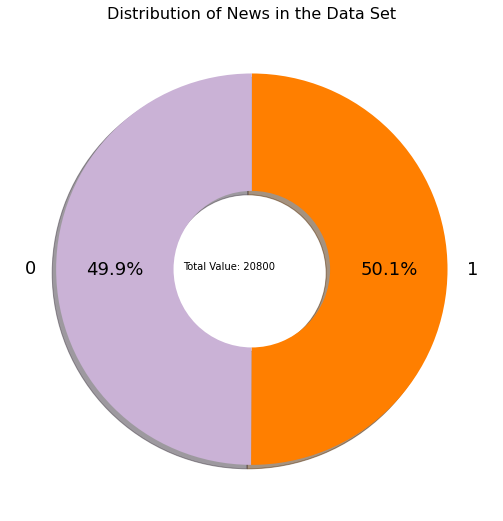

In [8]:
plt.figure(figsize = (9,9))
sorted_counts = train['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 18}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Value: {}'.format(train.shape[0]))
plt.title('Distribution of News in the Data Set', fontsize = 16);

<a id="3"></a> <br>

# Veri Önişleme

In [9]:
train.dropna(inplace=True)

In [10]:
train.reset_index(inplace=True)

In [11]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [12]:
test['text'].fillna('TEST',inplace=True)


In [13]:
test.text.isnull().sum()

0

In [14]:
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

<a id="4"></a> <br>

# Özel Karakterlerin Temizlenmesi

In [15]:
def ozel_karakter (text):
    punctation = string.punctuation
    return text.translate(str.maketrans("","",punctation))


train["text"] = train["text"].apply(lambda x: ozel_karakter(x))
train["text"] = train["text"].str.lower()
train["text"] = train["text"].str.split()
# Test veri setine uygulanması
test["text"] = test["text"].apply(lambda x: ozel_karakter(x))
test["text"] = test["text"].str.lower()
test["text"] = test["text"].str.split()

<a id="5"></a> <br>

# Tokenization

In [16]:
def stop_words_temizle (text):
    words = set(stopwords.words("english"))
    return [i for i in text if i not in words]

train["text"] = train["text"].apply(lambda x : stop_words_temizle(x))
test["text"] = test["text"].apply(lambda x : stop_words_temizle(x))

<a id="6"></a> <br>

# Lemmatize

In [17]:
def lemmatizasyon (text):
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(word= i , pos="v") for i in text]

train["text"] = train["text"].apply(lambda x: lemmatizasyon(x))
test["text"] = test["text"].apply(lambda x: lemmatizasyon(x))

<a id="7"></a> <br>

# Veri Setinden Gürültülerin Silinmesi

In [18]:
def gurultu_sil (text):
    return (' '.join([w for w in text if len(w)>2]))

train["text"] = train["text"].apply(lambda x : gurultu_sil(x))
test["text"] = test["text"].apply(lambda x : gurultu_sil(x))

<a id="8"></a> <br>

# Veri Setinin Hazırlanması

In [19]:
X = train["text"]
y = train["label"]

In [20]:
X.shape

(18285,)

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [22]:
voc_size=4701

In [23]:
X=X.reset_index()

In [24]:
X=X.drop(['index'],axis=1)

In [25]:
y=y.reset_index()

In [26]:
y=y.drop(['index'],axis=1)

<a id="9"></a> <br>

# OneHot Encoding

In [27]:
onehot_repr=[one_hot(words,voc_size)for words in X["text"] ]

In [28]:
len(onehot_repr[0])

444

In [29]:
len(onehot_repr[700])

363

In [30]:
sent_length=700


embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2897 3086 4464]
 [   0    0    0 ... 1652 1930 2276]
 [   0    0    0 ... 2519  592  275]
 ...
 [   0    0    0 ... 2418 3880 3209]
 [   0    0    0 ...    1 3934 1384]
 [   0    0    0 ...  167 2508 2923]]


In [31]:

from tensorflow.keras.layers import Dropout

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [33]:
X_final.shape,y_final.shape

((18285, 700), (18285, 1))

<a id="10"></a> <br>

# Eğitim ve Test Veri Setinin Ayrılması Ve Modelin Uygulanması

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.10, random_state=42)

In [35]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)

Epoch 1/5
258/258 [==============================] - 168s 649ms/step - loss: 0.3733 - accuracy: 0.8360 - val_loss: 0.2920 - val_accuracy: 0.8923
Epoch 2/5
258/258 [==============================] - 166s 645ms/step - loss: 0.2203 - accuracy: 0.9153 - val_loss: 0.3920 - val_accuracy: 0.8059
Epoch 3/5
258/258 [==============================] - 175s 680ms/step - loss: 0.2350 - accuracy: 0.9056 - val_loss: 0.2493 - val_accuracy: 0.9103
Epoch 4/5
258/258 [==============================] - 174s 675ms/step - loss: 0.1610 - accuracy: 0.9412 - val_loss: 0.2934 - val_accuracy: 0.9027
Epoch 5/5
258/258 [==============================] - 174s 674ms/step - loss: 0.1304 - accuracy: 0.9542 - val_loss: 0.2404 - val_accuracy: 0.9120


In [36]:
test=test.drop(['title','id','author'],axis=1)

In [37]:
test.isnull().sum()

text    0
dtype: int64

In [38]:
onehot_repr_test=[one_hot(words,voc_size)for words in test["text"]]

In [39]:
sent_length=700


embedded_docs_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[ 223 3031 2534 ...  747 4566 2566]
 [   0    0    0 ... 3747 4016 3995]
 [   0    0    0 ... 1088 2229 1036]
 ...
 [   0    0    0 ... 2187 3463  141]
 [   0    0    0 ... 2888 1457 1326]
 [4476 1330 2554 ... 1058 2161 3751]]


In [40]:
X_test=np.array(embedded_docs_test)

In [41]:
check=model.predict_classes(X_test)

In [42]:
check

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

In [43]:
check.shape

(5200, 1)

In [44]:
test.shape


(5200, 1)

In [45]:
type(check)

numpy.ndarray

<a id="11"></a> <br>
# Submit

In [46]:
label=[]
for i in check:
    label.append(i[0])

In [47]:
submit["label"] = label

In [48]:
submit.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [49]:
submit.to_csv('submission_first.csv', index=False)
from IPython.display import FileLink
FileLink(r'submission_first.csv')

/kaggle/working/submission_first.csv